#Image classification of Cifar 10 dataset using DavidResnet CNN model , albumentation image augmentation, OnecycleLR and gradcam image

### Submitted by Deepak Hazarika  , Parinita Bora , Gurudatta

In [1]:
!python --version

Python 3.6.9


In [2]:
!pip install PyDrive

## Import pydrive modules

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)




## Upload the cifar 10 image files from google drive to colab

Instead of downloading the cifar 10 dataset from web , a copy is saved in google drive.

In [5]:

downloaded = drive.CreateFile({'id':"1fohphdiuj_-zG7EwFnRzj4NQ3rZRu_PY"})   # replace the id with id of file you want to access
downloaded.GetContentFile('cifar10.zip')

In [6]:
from zipfile import ZipFile

## Extract the images into a local folder

In [7]:
with ZipFile('/content/cifar10.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

### Initialize the parameters 

The input from LRfinder is used to set the max lr and min lr for OneCycle LR policy.

*   max_lr = 4 * (0.118)
*   min_lr = max_lr / 5
*   stepsize = 5 epoch





In [8]:
EPOCHS = 24
MLTPR = 4
BATCH_SIZE = MLTPR*128 
WEIGHT_DECAY = 1e-2
TRAIN_DATASET_SIZE = 50000
BUCKET_SIZE = 5
NUMBER_OF_BATCHES =  TRAIN_DATASET_SIZE // BATCH_SIZE
NUMBER_OF_BUCKETS = NUMBER_OF_BATCHES // BUCKET_SIZE
DATAFOLDER = "/content/cifar10/"
NUM_LR_FINDER_ITER = 5859 # (i epoch = 50000/batch size , number of iter = iter per epoch * epoch , 50000/128 = 301 , 1954 = 391 * 5)
END_LR = MLTPR* 0.118
START_LR = 1e-5
FACTOR=5
NUMBER_OF_STEPS =4.5
STEPSIZE = EPOCHS//NUMBER_OF_STEPS
ANNEAL_EPOCH = 2

## Import the model library from https://github.com/tfdeepnet/visionlib.git

In [10]:
!git clone https://github.com/tfdeepnet/visionlib.git

Cloning into 'visionlib'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 439 (delta 46), reused 49 (delta 24), pack-reused 365
Receiving objects: 100% (439/439), 128.12 KiB | 351.00 KiB/s, done.
Resolving deltas: 100% (268/268), done.


In [11]:
!pip install -e /content/visionlib 


Obtaining file:///content/visionlib
  Running setup.py develop for visionlib


In [12]:
import visionlib.models as vl
import visionlib.utils as utl
#import visionlib.albumentations as A


In [14]:
%matplotlib inline

## Import the libraries

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import cv2
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

## Prepare a list of albumentation for train and test data 





In [16]:
import albumentations as A

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform_list = [A.PadIfNeeded (min_height=40, min_width=40,border_mode=cv2.BORDER_CONSTANT, value=0 , always_apply=True),
                        A.RandomCrop(32,32),
                        A.HorizontalFlip(),
                        A.Normalize(mean=channel_means, std=channel_stdevs),
                        A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1)]
# Test Phase transformations
test_transform_list = [A.Normalize(mean=channel_means, std=channel_stdevs)]

##  Use the loaddata utility from visionlib library to load train and test data

In [17]:
trainloader, testloader = utl.loadalbumentationdata(DATAFOLDER , BATCH_SIZE , train_transform_list, test_transform_list )


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.



img shape  torch.Size([512, 3, 32, 32])


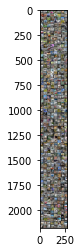

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("img shape " , images.shape)


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Instantiate a DaidResnet model to train and test the cifar 10 dataset


In [19]:
net = vl.DavidResNet()

### Get the model summary alongwith the recepive field at each layer

In [20]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

utl.summary(net.to(device), input_size=(3, 32, 32))

cuda
-----------------------------------------------------------------------------------------------
        Layer (type) |              Output Shape |         Param # |          RF out |         Jump in
            Conv2d-1 |          [-1, 64, 32, 32] |           1,728 |               3 |               1
       BatchNorm2d-2 |          [-1, 64, 32, 32] |             128 |               0 |               0
            Conv2d-3 |         [-1, 128, 32, 32] |          73,728 |               5 |               1
         MaxPool2d-4 |         [-1, 128, 16, 16] |               0 |               6 |               1
       BatchNorm2d-5 |         [-1, 128, 16, 16] |             256 |               0 |               0
            Conv2d-6 |         [-1, 128, 16, 16] |         147,456 |              10 |               2
       BatchNorm2d-7 |         [-1, 128, 16, 16] |             256 |               0 |               0
            Conv2d-8 |         [-1, 128, 16, 16] |         147,456 |       

(tensor(6713674), tensor(6713674))

https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee

## Plot CyclicalLR graph 

[0.0944, 0.1888, 0.2832, 0.3776, 0.472, 0.3776, 0.2832, 0.1888, 0.0944, 0.1888, 0.2832, 0.3776, 0.472, 0.3776, 0.2832, 0.1888, 0.0944, 0.1888, 0.2832, 0.3776, 0.472, 0.3776, 0.2832, 0.1888, 0.0944]


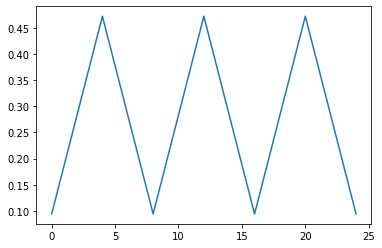

In [54]:
import math

yl = []
for it in range(24+1):
  lro = utl.cyclical_lr(4, min_lr=END_LR/FACTOR, max_lr=END_LR)(it)
  yl.append(lro)

plt.plot(yl)
print(yl)

## Plot OneCycleLr graph

[0.0944, 0.16991999999999996, 0.24544, 0.32095999999999997, 0.39648, 0.472, 0.45311999999999997, 0.43423999999999996, 0.41535999999999995, 0.39648, 0.3776, 0.35872, 0.33984, 0.32095999999999997, 0.30208, 0.2832, 0.26432, 0.24544, 0.22655999999999998, 0.20768000000000003, 0.1888, 0.16991999999999996, 0.04248000000000001, 0.028319999999999994]


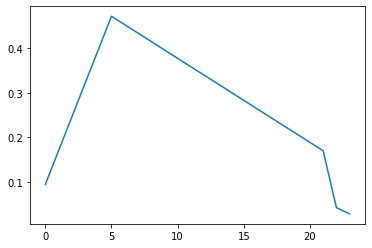

In [55]:
yl = []
for it in range(24):
  lro = utl.one_Cycle_lr(STEPSIZE, EPOCHS, ANNEAL_EPOCH, min_lr=END_LR/FACTOR, max_lr=END_LR)(it)
  yl.append(lro)

plt.plot(yl)
print(yl)

## Apply the optimum LR found by LR finder

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1.)
clr = utl.one_Cycle_lr(STEPSIZE, EPOCHS, ANNEAL_EPOCH, min_lr=END_LR/FACTOR, max_lr=END_LR)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [clr])

## Train the network for 24 epochs



In [57]:
train_loss = [] 
train_acc = []
test_loss = []
test_acc = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print("Epoch:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
    utl.train(epoch , trainloader, optimizer, net, criterion, NUMBER_OF_BUCKETS , device )
    test_loss,test_acc = utl.test(testloader, net, criterion , device )
    train_loss,train_acc = utl.train_metrics(trainloader, net, criterion , device )
    scheduler.step()#test_acc[-1])            

print('Finished Training')

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 1 LR: 0.0944


Loss=1.1857134103775024 Batch_id=97 Accuracy=40.71: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]



Test set: Average loss: 0.0028, Accuracy: 5011/10000 (50.11%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 2 LR: 0.16991999999999996


Loss=1.0478315353393555 Batch_id=97 Accuracy=52.24: 100%|██████████| 98/98 [00:26<00:00,  3.66it/s]



Test set: Average loss: 0.0025, Accuracy: 5941/10000 (59.41%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 3 LR: 0.24544


Loss=1.0992376804351807 Batch_id=97 Accuracy=59.16: 100%|██████████| 98/98 [00:27<00:00,  3.59it/s]



Test set: Average loss: 0.0023, Accuracy: 6200/10000 (62.00%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 4 LR: 0.32095999999999997


Loss=0.8629339337348938 Batch_id=97 Accuracy=65.40: 100%|██████████| 98/98 [00:27<00:00,  3.62it/s]



Test set: Average loss: 0.0028, Accuracy: 6172/10000 (61.72%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 5 LR: 0.39648


Loss=0.8227150440216064 Batch_id=97 Accuracy=68.65: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0022, Accuracy: 6502/10000 (65.02%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 6 LR: 0.472


Loss=0.690125584602356 Batch_id=97 Accuracy=72.30: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0030, Accuracy: 6070/10000 (60.70%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 7 LR: 0.45311999999999997


Loss=0.6961143612861633 Batch_id=97 Accuracy=76.23: 100%|██████████| 98/98 [00:27<00:00,  3.59it/s]



Test set: Average loss: 0.0021, Accuracy: 6859/10000 (68.59%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 8 LR: 0.43423999999999996


Loss=0.5811417698860168 Batch_id=97 Accuracy=78.74: 100%|██████████| 98/98 [00:27<00:00,  3.61it/s]



Test set: Average loss: 0.0013, Accuracy: 7921/10000 (79.21%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 9 LR: 0.41535999999999995


Loss=0.5548186898231506 Batch_id=97 Accuracy=80.48: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0013, Accuracy: 7935/10000 (79.35%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 10 LR: 0.39648


Loss=0.5084803700447083 Batch_id=97 Accuracy=81.93: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0012, Accuracy: 8022/10000 (80.22%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 11 LR: 0.3776


Loss=0.4964086413383484 Batch_id=97 Accuracy=82.93: 100%|██████████| 98/98 [00:27<00:00,  3.61it/s]



Test set: Average loss: 0.0013, Accuracy: 8084/10000 (80.84%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 12 LR: 0.35872


Loss=0.5680851340293884 Batch_id=97 Accuracy=83.73: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0012, Accuracy: 8162/10000 (81.62%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 13 LR: 0.33984


Loss=0.41301241517066956 Batch_id=97 Accuracy=85.16: 100%|██████████| 98/98 [00:27<00:00,  3.61it/s]



Test set: Average loss: 0.0009, Accuracy: 8429/10000 (84.29%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 14 LR: 0.32095999999999997


Loss=0.383761465549469 Batch_id=97 Accuracy=85.52: 100%|██████████| 98/98 [00:27<00:00,  3.58it/s]



Test set: Average loss: 0.0011, Accuracy: 8279/10000 (82.79%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 15 LR: 0.30208


Loss=0.32255882024765015 Batch_id=97 Accuracy=86.69: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0010, Accuracy: 8472/10000 (84.72%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 16 LR: 0.2832


Loss=0.4494434595108032 Batch_id=97 Accuracy=87.03: 100%|██████████| 98/98 [00:27<00:00,  3.61it/s]



Test set: Average loss: 0.0008, Accuracy: 8704/10000 (87.04%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 17 LR: 0.26432


Loss=0.2864599823951721 Batch_id=97 Accuracy=87.79: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0008, Accuracy: 8780/10000 (87.80%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 18 LR: 0.24544


Loss=0.4143424332141876 Batch_id=97 Accuracy=88.36: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0008, Accuracy: 8798/10000 (87.98%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 19 LR: 0.22655999999999998


Loss=0.25640782713890076 Batch_id=97 Accuracy=89.09: 100%|██████████| 98/98 [00:27<00:00,  3.61it/s]



Test set: Average loss: 0.0009, Accuracy: 8587/10000 (85.87%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 20 LR: 0.20768000000000003


Loss=0.3189050257205963 Batch_id=97 Accuracy=89.65: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0009, Accuracy: 8658/10000 (86.58%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 21 LR: 0.1888


Loss=0.2193135768175125 Batch_id=97 Accuracy=90.03: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0007, Accuracy: 8862/10000 (88.62%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 22 LR: 0.16991999999999996


Loss=0.30214211344718933 Batch_id=97 Accuracy=90.46: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0007, Accuracy: 8869/10000 (88.69%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 23 LR: 0.04248000000000001


Loss=0.2326720952987671 Batch_id=97 Accuracy=91.83: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0006, Accuracy: 9121/10000 (91.21%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 24 LR: 0.028319999999999994


Loss=0.2616382837295532 Batch_id=97 Accuracy=92.06: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0005, Accuracy: 9131/10000 (91.31%)

Finished Training


### Let us display a batch of image from the test set to get familiar.



GroundTruth:  truck  ship truck plane plane horse  deer  frog  bird   dog  deer  bird   cat   car   cat truck horse   car  frog   cat horse truck   dog plane  frog   cat  bird plane   car  ship  ship  deer  bird  deer   dog plane  ship  deer   dog  deer  frog  bird  frog   cat truck  frog  frog   car   dog horse  ship plane   dog plane   cat plane  bird  frog horse  ship truck  deer horse   car  deer   dog horse  ship plane truck   cat  ship truck  ship  bird   cat   car  frog truck plane   dog  frog plane truck horse truck  deer   car truck  bird truck  ship plane truck horse   dog plane plane truck truck   car   cat  deer truck plane   dog  bird plane plane  frog  deer horse  bird  bird plane  bird   dog   cat  frog  deer plane  deer  ship plane   car   car plane  deer plane   dog  bird   car   car  frog truck  frog plane  deer  frog  bird  deer   cat horse  deer  frog horse  frog  ship  bird horse truck  bird  bird  frog  deer horse   dog   cat  bird truck   cat   dog truck   car  f

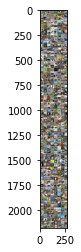

In [58]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

## Test accuracy at each class level

In [59]:
   
misclassifiedimages = utl.get_validation_result_and_misclassifiedimages(net , device , classes , testloader ) 

Class accuracy 

Accuracy of plane : 92 % 

Accuracy of   car : 97 % 

Accuracy of  bird : 88 % 

Accuracy of   cat : 81 % 

Accuracy of  deer : 91 % 

Accuracy of   dog : 84 % 

Accuracy of  frog : 93 % 

Accuracy of horse : 95 % 

Accuracy of  ship : 95 % 

Accuracy of truck : 93 % 


 Accuracy of the network on the 10000 test images: 91.31 %


## Test accuracy 91.31% (randomly picking a class out of 10 classes).
Seems like the network learnt something.

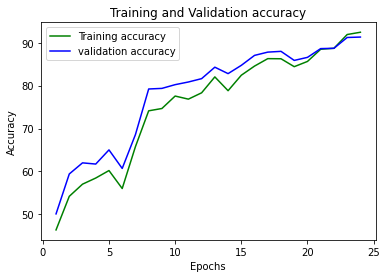

In [62]:
utl.plot_train_vs_test_accuracy(EPOCHS , train_acc , test_acc)

## Visualize misclassified test images

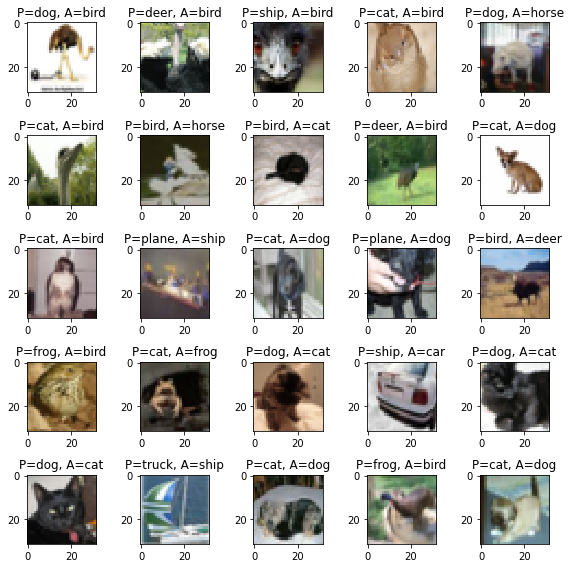

In [63]:
utl.view_misclassified_images(misclassifiedimages , classes)

In [64]:

import numpy as np
import matplotlib.pyplot as plt

def imshowgradcam(img,c = "" ):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

## GradCam of misclassified images

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

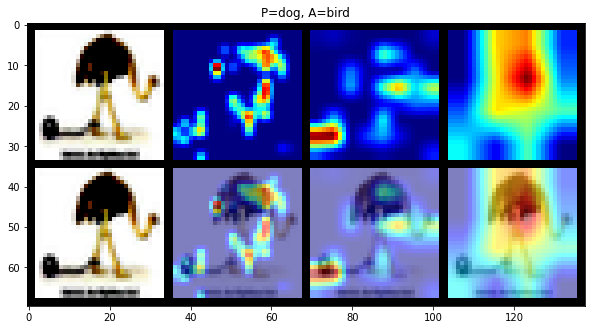

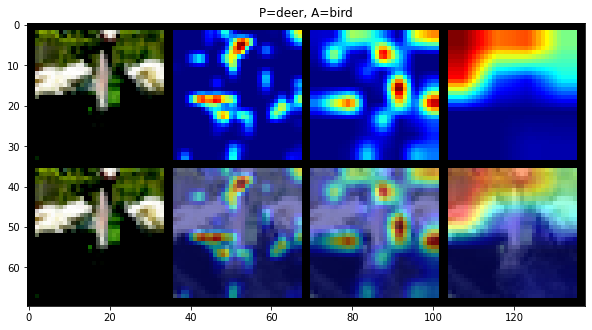

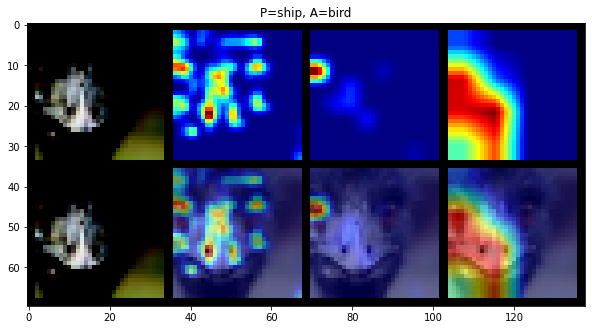

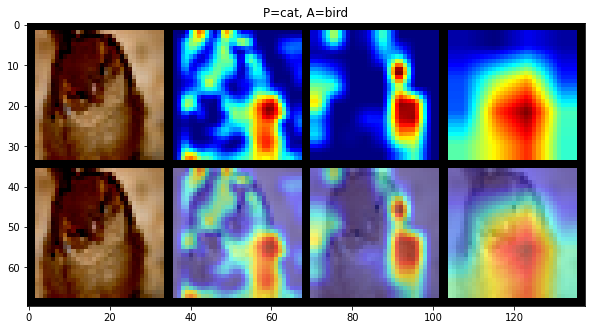

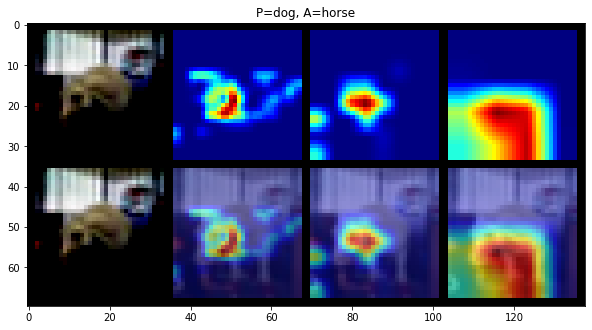

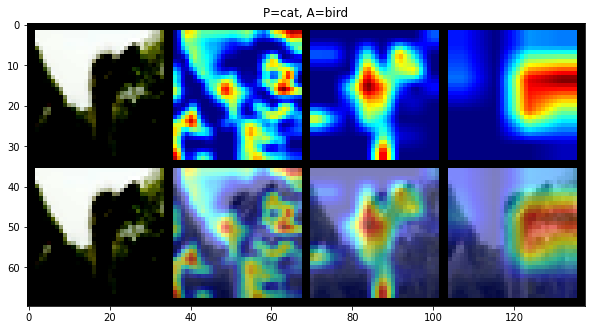

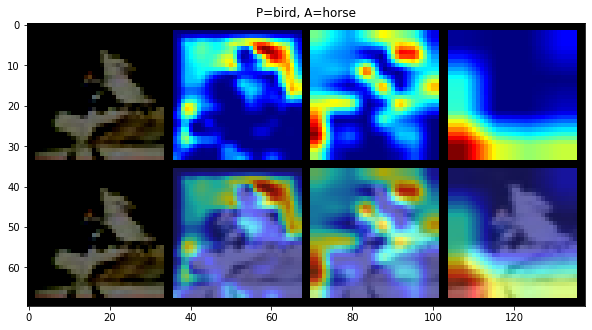

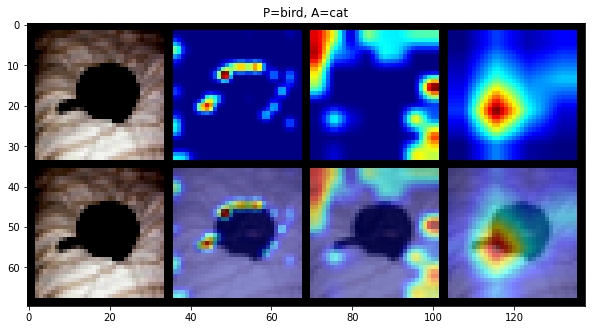

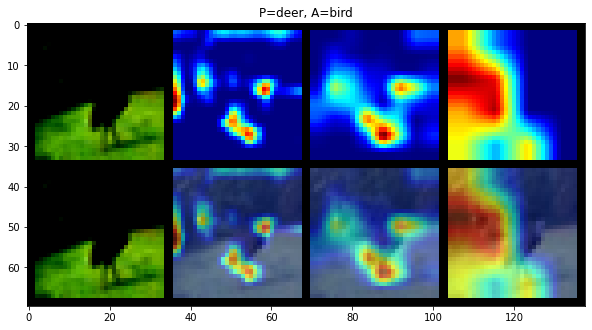

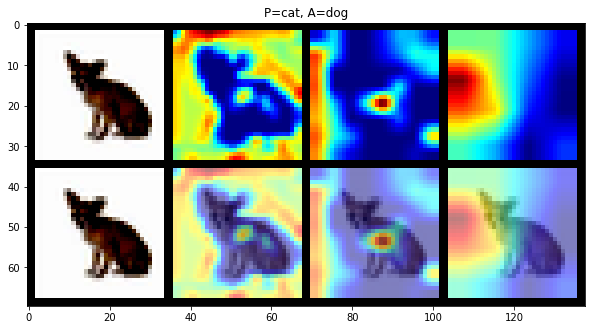

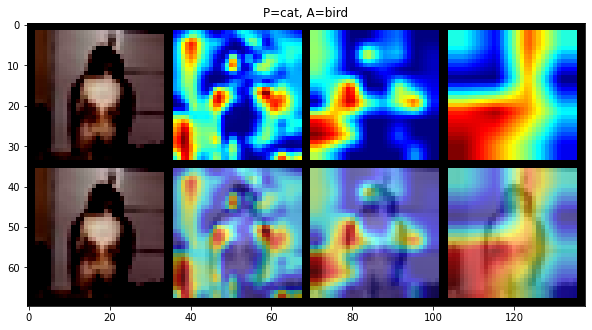

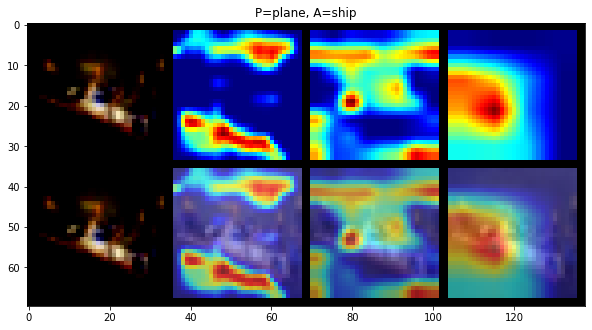

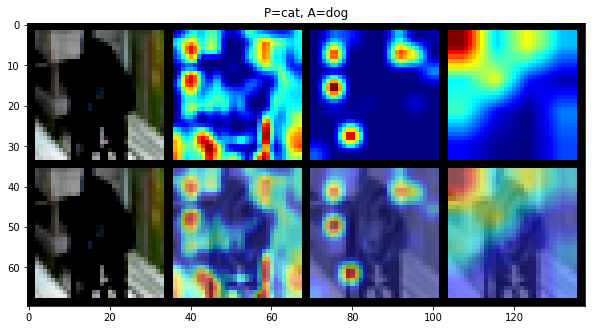

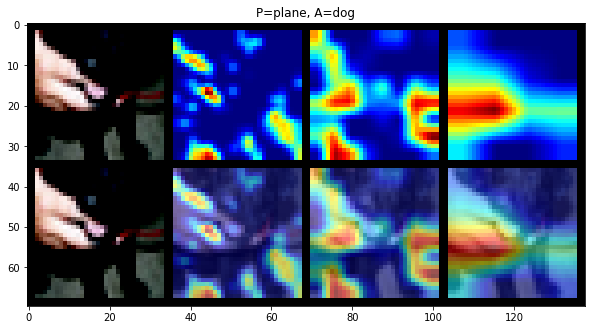

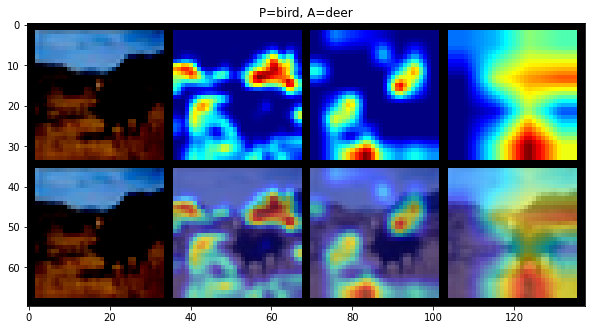

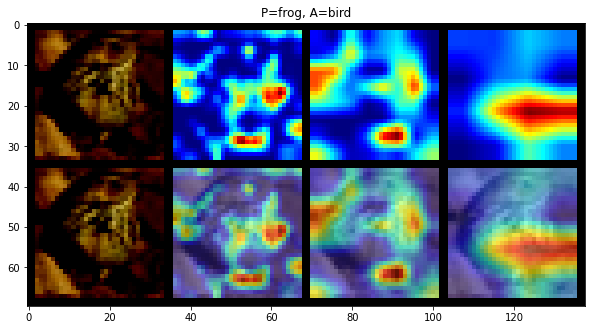

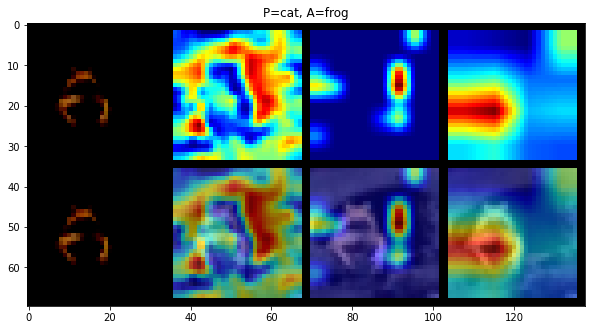

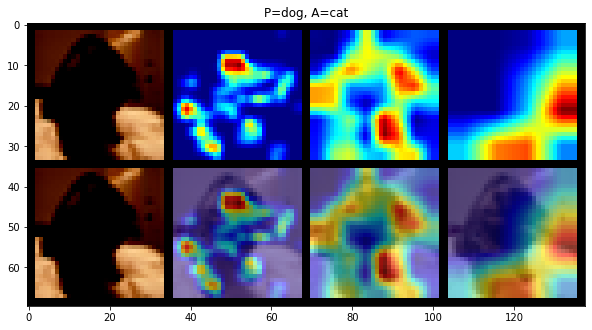

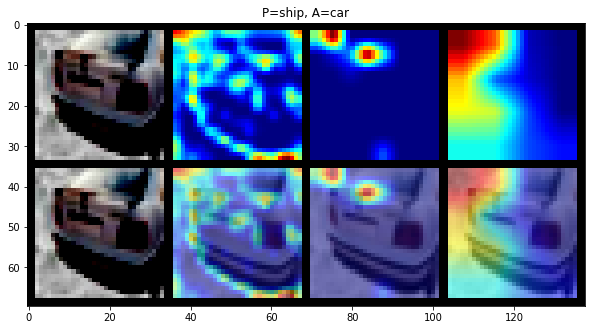

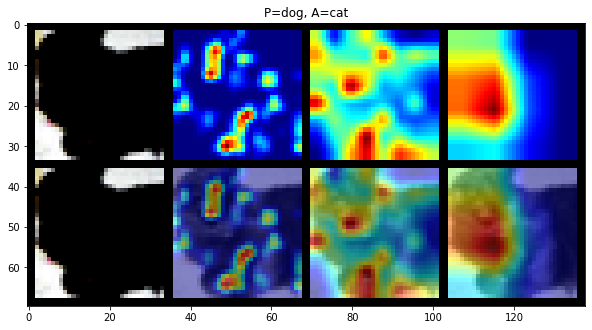

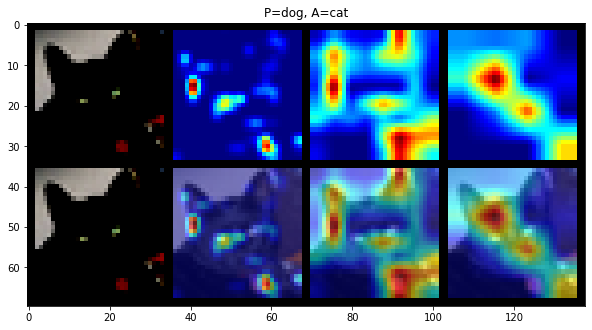

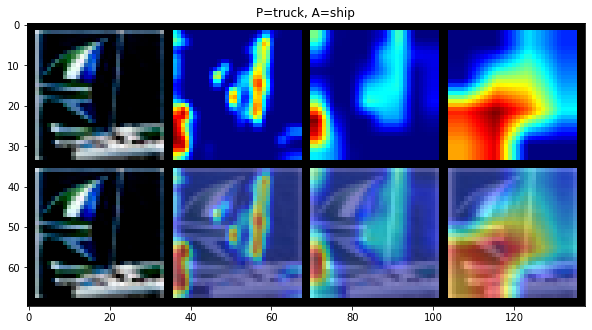

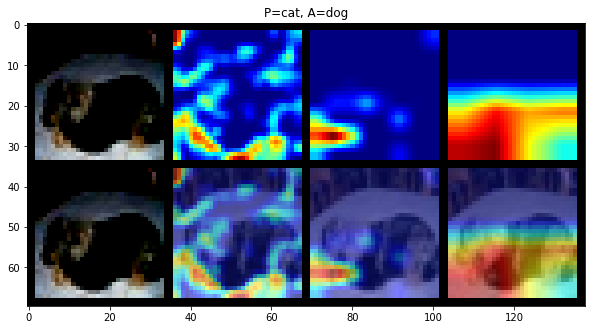

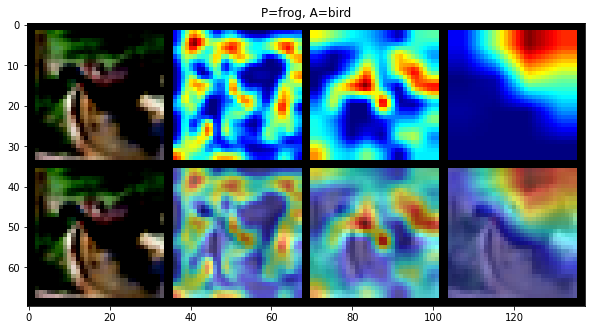

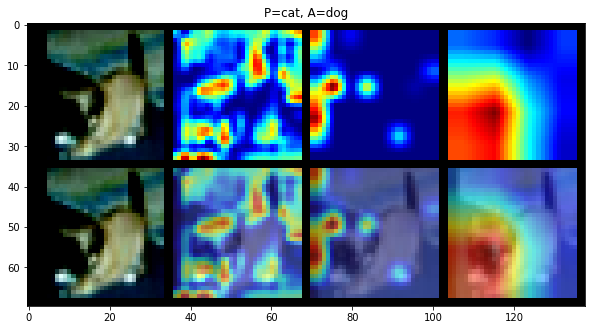

In [65]:
import copy
from torchvision.utils import make_grid, save_image
for i,k in enumerate(misclassifiedimages):
  images1 = [misclassifiedimages[i][0].cpu()]
  images2 =  [misclassifiedimages[i][0].cpu()]
  b = copy.deepcopy(net.to(device))
  output = net(misclassifiedimages[i][0].unsqueeze(0))
  _, predicted = torch.max(output.data, 1)
  layers =  [b.layer1,b.layer2,b.layer3]
  for j in layers:
    g = utl.GradCAM(b,j)
    # mask, _= g(gradcam_misclassified_images[i][0].unsqueeze(0))
    # heatmap, result = visualize_cam(mask,gradcam_misclassified_images[i][0])
    mask, _= g(misclassifiedimages[i][0].clone().unsqueeze_(0))
    heatmap, result = utl.visualize_cam(mask,misclassifiedimages[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=4)
  # imshow(grid_image,c = classes[int(predicted)])
  imshowgradcam(grid_image,c = "P={}, A={}".format(str(classes[misclassifiedimages[i][1].data.cpu().numpy()]),str(classes[misclassifiedimages[i][2].data.cpu().numpy()])))